# Clustering Analysis – Customer Segmentation

## 1. Dataset Selection and Inspection

#### Dataset structure details, including column names, non-null values, and data types, are provided, while duplicate rows are counted and reported for data cleaning.

In [1]:
import pandas as pd
df = pd.read_csv("customer_data.csv")
print(df.shape)  
print(df.info())  
print(df.describe())  
print(f"Duplicates: {df.duplicated().sum()}")

(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual_Income_(k$)  Spending_Score
count  200.000000  200.000000          200.000000      200.000000
mean   100.500000   38.850000           60.560000       50.200000
std     57.879185   13.969007           26.264721       25.823522
min      1.000000   18.000000           15.000000        1.000000
25%     50.750000   28.750000           41.500000       34.750000
50%    100.500000   36.000000           61.500000       50.000000
75%    150.250000   49.000000     

## 2. Data Preprocessing

#### Numerical columns are selected while dropping missing values to ensure clean data. Standardization is applied using StandardScaler, transforming the data into a uniform scale, which helps improve the performance of machine learning models.

In [2]:
from sklearn.preprocessing import StandardScaler
df_numeric = df.select_dtypes(include=["number"]).dropna()
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

## 3. Clustering

#### The Within-Cluster Sum of Squares (WCSS) is calculated for different cluster counts to evaluate clustering compactness. The Elbow Method plot visualizes WCSS against the number of clusters, helping to identify the optimal cluster count where the curve bends.

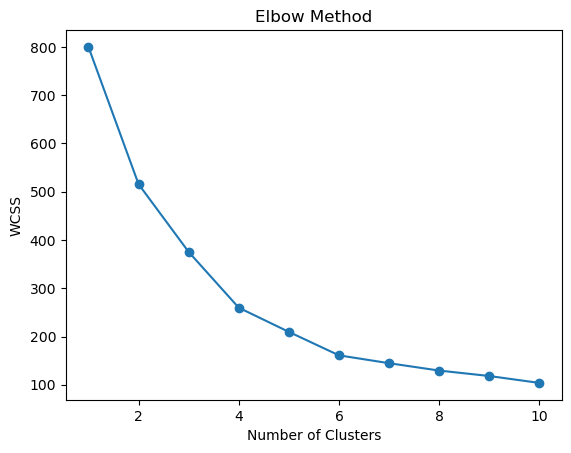

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = [] 
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(K_range, wcss, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

#### Silhouette scores assess clustering quality, with the plot helping to identify the optimal number of clusters based on the highest score.

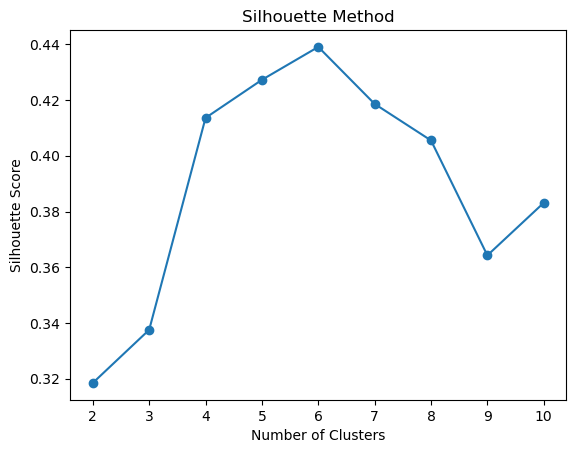

In [4]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

plt.plot(range(2, 11), silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()

#### K-Means is applied with the optimal cluster count, assigning each data point to a cluster and storing the labels in the dataset.

In [5]:
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_scaled)

## 4. Visualization

#### PCA reduces the dataset to two dimensions for visualization, allowing clusters to be plotted in a scatter plot with distinct colors for better interpretation.

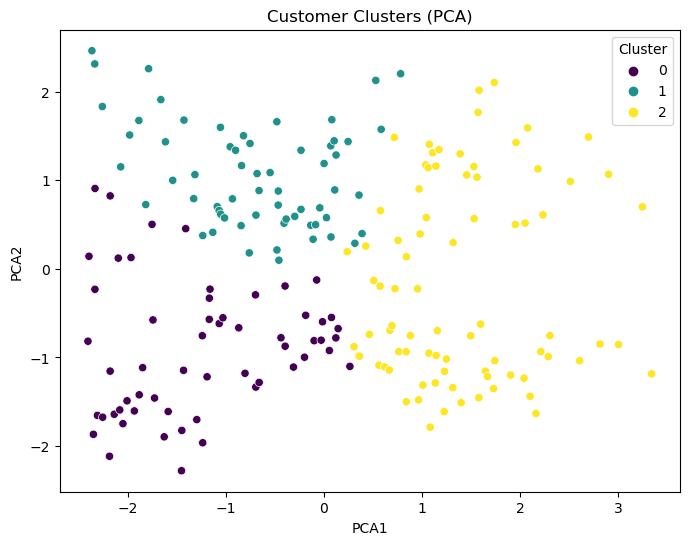

In [6]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df["PCA1"], df["PCA2"] = df_pca[:, 0], df_pca[:, 1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=df["Cluster"], palette="viridis", data=df)
plt.title("Customer Clusters (PCA)")
plt.show()

#### A pair plot visualizes relationships between features across clusters, with kernel density estimation (KDE) on the diagonal to show feature distributions.

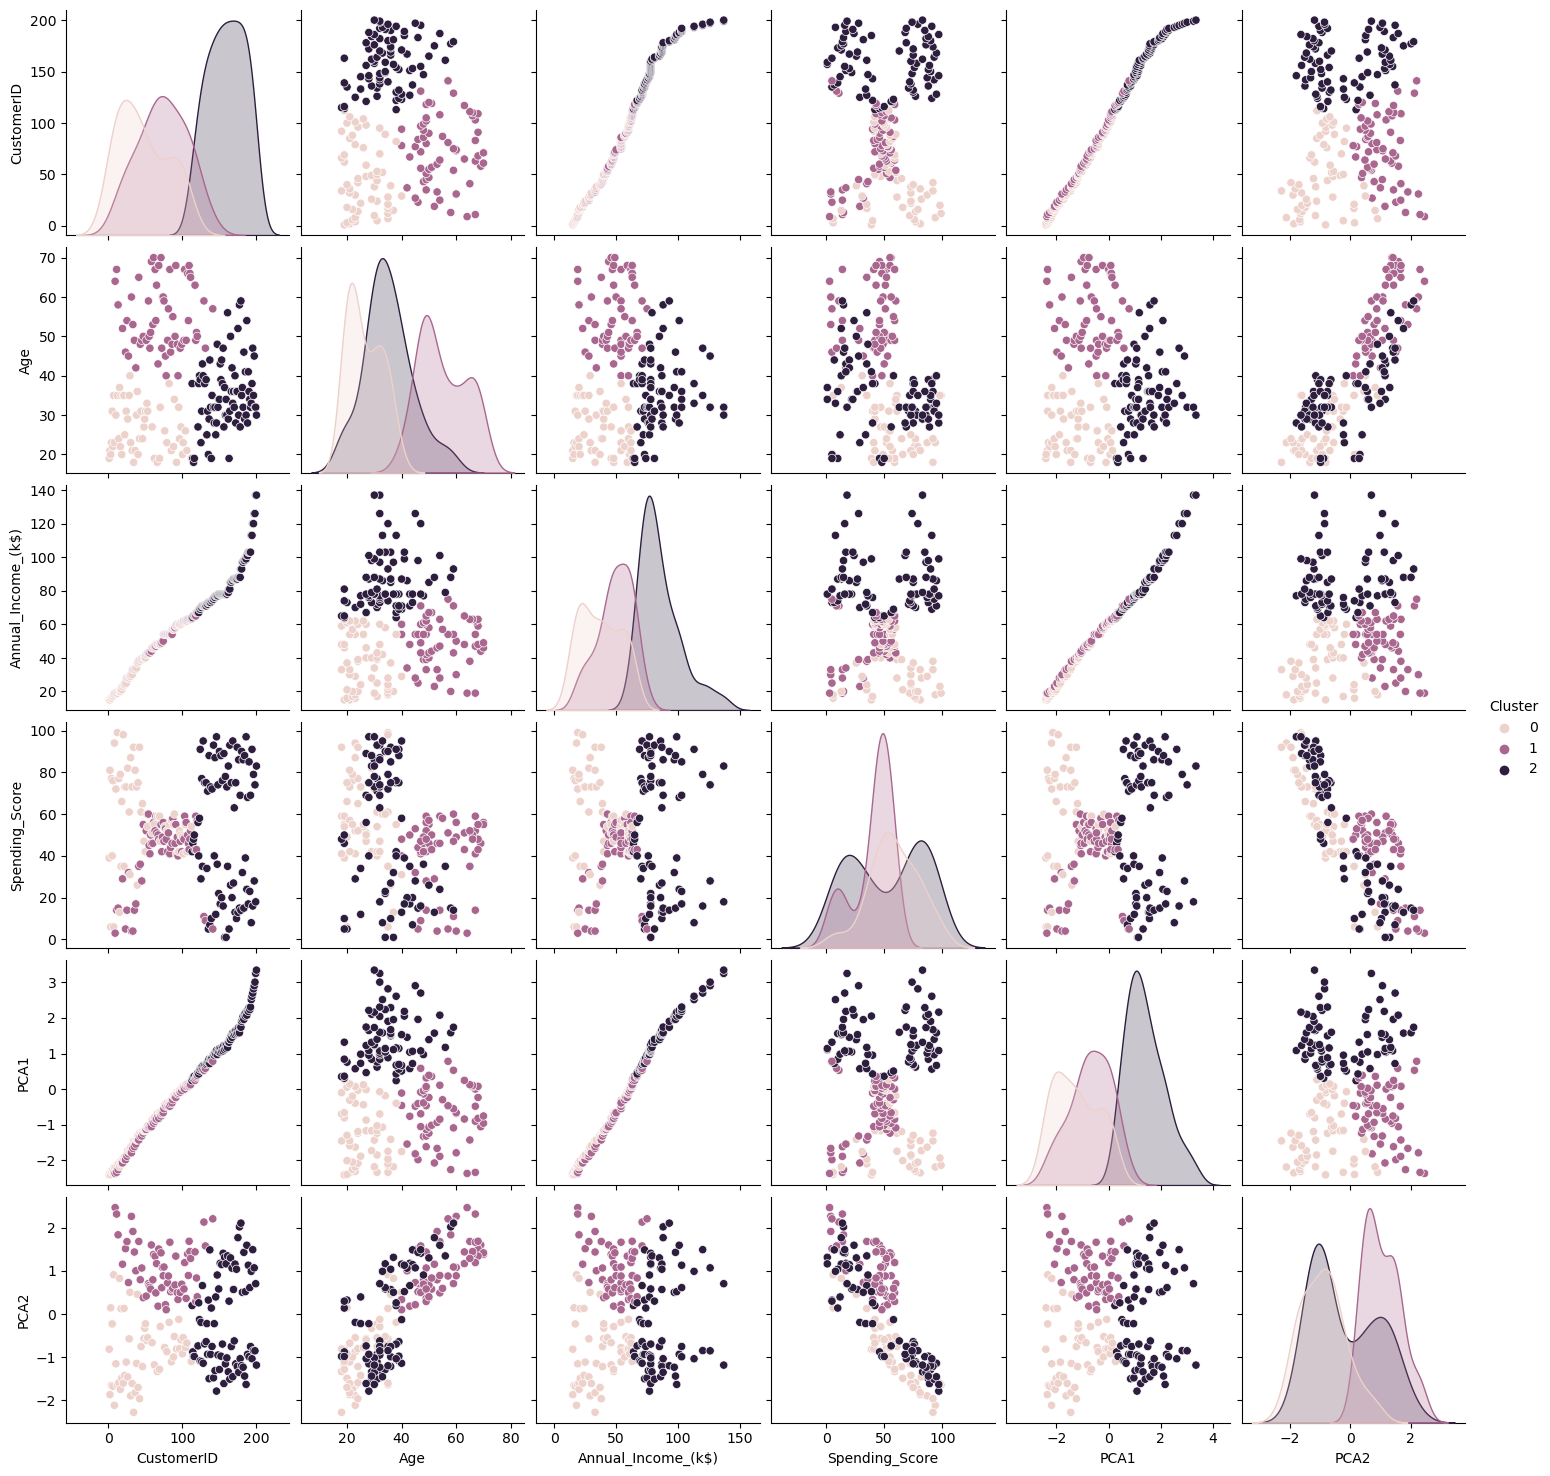

In [7]:
sns.pairplot(df, hue="Cluster", diag_kind="kde")
plt.show()

#### Cluster centroids are transformed back to the original scale and visualized using a bar plot, highlighting key feature values for each cluster to aid in interpretation.

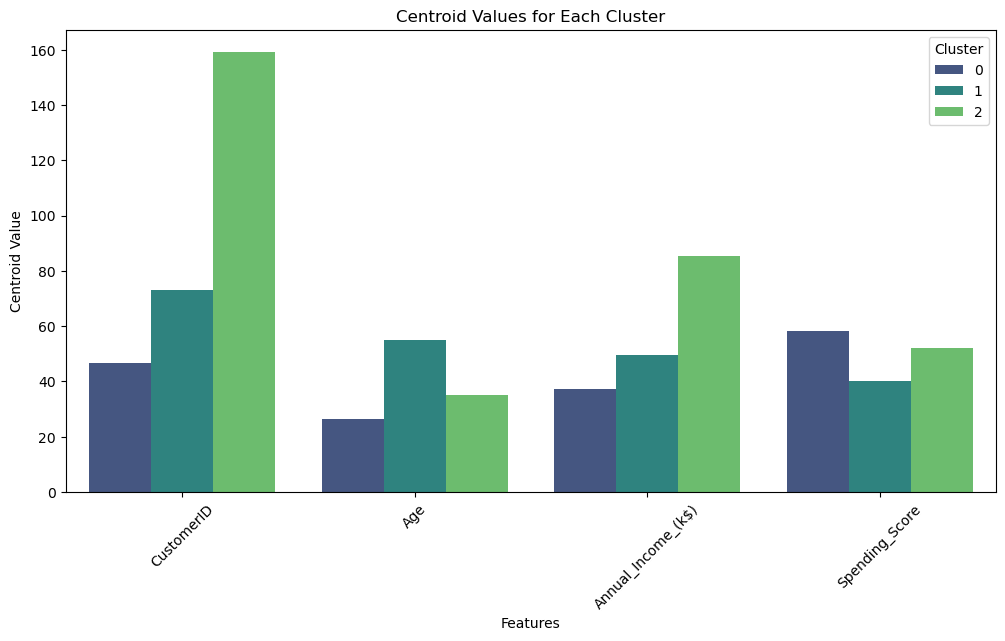

In [8]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=df_numeric.columns)
centroid_df["Cluster"] = range(optimal_k)
centroid_melted = pd.melt(centroid_df, id_vars=["Cluster"], var_name="Feature", value_name="Centroid Value")
plt.figure(figsize=(12, 6))
sns.barplot(x="Feature", y="Centroid Value", hue="Cluster", data=centroid_melted, palette="viridis")
plt.xticks(rotation=45)
plt.title("Centroid Values for Each Cluster")
plt.xlabel("Features")
plt.ylabel("Centroid Value")
plt.legend(title="Cluster")
plt.show()